In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from collections import Counter

In [2]:
def read_image(image_path):
    img = Image.open(image_path)
    img_array = np.array(img)
    return img_array

In [3]:
image_path = "slider_puffin_before_mobile.jpg"
image_array = read_image(image_path)

In [4]:
import cv2
# read image
imgOriginal = cv2.imread('slider_puffin_before_mobile.jpg', cv2.IMREAD_COLOR)
image_array = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2RGB)

In [5]:
image_array.shape

(800, 800, 3)

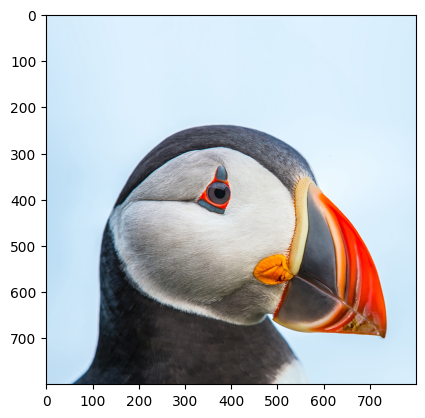

In [6]:
plt.imshow(image_array)

In [7]:
def calculate_image_size(image):
    """
    Calculates the size of the image in bits.
    
    Args:
        image: The image data.
        
    Returns:
        int: The size of the image in bits.
    """
    width, height, channels = image.shape
    bits_per_channel = 8  # Assuming 8 bits per channel
    
    image_size_in_bits = width * height * channels * bits_per_channel
    return image_size_in_bits


In [8]:
print(f'uncompressed: {calculate_image_size(image_array) / (8 * 1000)} KB')

uncompressed: 1920.0 KB


In [9]:
def rgb_to_ycbcr(image):
    ycbcr_array = np.zeros_like(image, dtype=np.float32)
    ycbcr_array[:, :, 0] = 0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] + 0.114 * image[:, :, 2]
    ycbcr_array[:, :, 1] = -0.1687 * image[:, :, 0] - 0.3313 * image[:, :, 1] + 0.5 * image[:, :, 2] + 128
    ycbcr_array[:, :, 2] = 0.5 * image[:, :, 0] - 0.4187 * image[:, :, 1] - 0.0813 * image[:, :, 2] + 128

    # Apply 4:2:2 subsampling
    low_chroma = ycbcr_array.copy()
    low_chroma[:, ::2, 1:] = 128
    return low_chroma.astype(np.uint8)


In [10]:
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

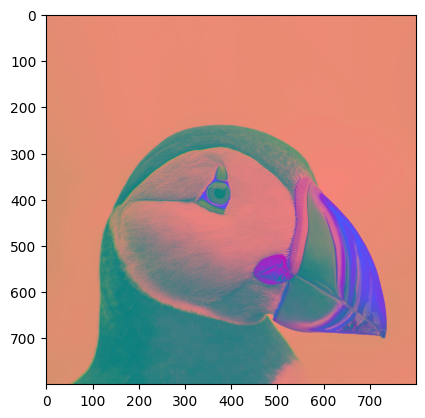

In [11]:
low_chroma_array = rgb2ycbcr(image_array)
# convert BGR to YCrCb
plt.imshow(low_chroma_array)

In [12]:
# plt.imshow(ycbcr2rgb(low_chroma_array))

In [13]:
def perform_dct(image):
    height, width, channels = image.shape
    blocks = []
    
    for y in range(0, height, 8):
        for x in range(0, width, 8):
            block = image[y:y+8, x:x+8]
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
            blocks.append(dct_block)
    
    return np.array(blocks)

In [14]:
dct_coefficients = perform_dct(low_chroma_array)

In [15]:
dct_coefficients

array([[[[ 7.87919201e+02,  2.26250000e+02,  7.43338472e+01],
         [ 7.88327449e+02,  2.26750000e+02,  7.46225223e+01],
         [ 7.88327449e+02,  2.26750000e+02,  7.46225223e+01],
         ...,
         [ 7.88123325e+02,  2.27250000e+02,  7.57772228e+01],
         [ 7.88939821e+02,  2.29250000e+02,  7.63545731e+01],
         [ 7.87919201e+02,  2.29250000e+02,  7.51998726e+01]],

        [[-1.89021740e+00, -1.47788146e+00,  1.13405299e-01],
         [-1.36706447e+00, -8.37152602e-01,  4.83330280e-01],
         [-1.36706447e+00, -8.37152602e-01,  4.83330280e-01],
         ...,
         [ 6.83532237e-01,  8.37152602e-01,  4.83330280e-01],
         [ 1.17275591e-01,  1.53067252e+00,  8.29263658e-02],
         [-1.93332112e+00,  2.02106516e+00, -7.66458603e-01]],

        [[ 1.56229857e-01, -1.35299025e-01, -4.55287168e-01],
         [ 5.33402097e-01,  3.26640741e-01, -1.88586120e-01],
         [ 5.33402097e-01,  3.26640741e-01, -1.88586120e-01],
         ...,
         [-2.66701048e-0

In [16]:
import heapq

def find_huffman(frequency_dict):
    """
    Builds a Huffman tree based on a frequency dictionary.
    :param frequency_dict: Frequency dictionary
    :return: Huffman tree
    """

    # Create a heap to store nodes
    heap = [[weight, [symbol, ""]] for symbol, weight in frequency_dict.items()]
    # Use heapq to convert the list into a min heap
    heapq.heapify(heap)

    while len(heap) > 1:
        # Pop two nodes with the smallest weight
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)

        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]

        # Merge the two nodes and push the result back into the heap
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    huffman_tree = heap[0][1:]
    huffman_tree.sort(key=lambda x: (len(x[-1]), x))
    huffman_dict = {item[0]: item[1] for item in huffman_tree}
    return huffman_dict


In [17]:
flattened_coefficients = dct_coefficients[1].flatten()
coefficient_counts = Counter(flattened_coefficients)
find_huffman(coefficient_counts)

{0.0: '1',
 76.21023553303058: '01010',
 228.0: '01011',
 788.7356971761835: '01100',
 -0.07030157834535161: '000000',
 -0.04697401286237388: '000001',
 0.08136137691302553: '000010',
 0.09614037019071565: '000011',
 0.12176590554643296: '000100',
 0.13286257213811475: '000110',
 0.13529902503654928: '000111',
 0.14433756729740646: '001000',
 0.1988428911044619: '001001',
 0.22094238269039462: '001010',
 0.3266407412190941: '001100',
 0.48333027984738347: '001101',
 0.5334020967941772: '001111',
 75.77722283113843: '010001',
 228.75: '010010',
 789.960442047575: '010011',
 -1.3670644737315067: '0110110',
 -0.837152601532152: '0110111',
 -0.4082482904638631: '0111000',
 -0.2719260308305602: '0111010',
 -0.25000000000000006: '0111011',
 -0.18858611987114288: '0111100',
 -0.1665200058287999: '0111110',
 -0.07811492852594563: '0111111',
 0.12274901103520863: '0001010',
 0.18023995550173694: '0001011',
 0.2943306148274675: '0010110',
 0.3181896451432086: '0010111',
 0.5196015146920724: '001

In [18]:
def quantize_dct_coefficients(dct_coefficients, quantization_matrix):
    quantization_matrix = np.transpose(quantization_matrix, (1, 2, 0))
    quantized_coefficients = np.round(dct_coefficients / quantization_matrix)
    return quantized_coefficients.astype(int)

In [19]:
quantization_matrix = np.array([
    [
        [16,  11,  10,  16,  24,  40,  51,  61],
        [12,  12,  14,  19,  26,  58,  60,  55],
        [14,  13,  16,  24,  40,  57,  69,  56],
        [14,  17,  22,  29,  51,  87,  80,  62],
        [18,  22,  37,  56,  68, 109, 103,  77],
        [24,  35,  55,  64,  81, 104, 113,  92],
        [49,  64,  78,  87, 103, 121, 120, 101],
        [72,  92,  95,  98, 112, 100, 103,  99]
    ],
    # Repeat the same matrix for chrominance (Cb and Cr) components
    [
        [17,  18,  24,  47,  99,  99,  99,  99],
        [18,  21,  26,  66,  99,  99,  99,  99],
        [24,  26,  56,  99,  99,  99,  99,  99],
        [47,  66,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99]
    ],
    # Repeat the same matrix for chrominance (Cb and Cr) components
    [
        [17,  18,  24,  47,  99,  99,  99,  99],
        [18,  21,  26,  66,  99,  99,  99,  99],
        [24,  26,  56,  99,  99,  99,  99,  99],
        [47,  66,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99]
    ]
])


In [20]:
quantized_coefficients = quantize_dct_coefficients(dct_coefficients, quantization_matrix)
quantized_coefficients

array([[[[49, 13,  4],
         [72, 13,  4],
         [79,  9,  3],
         ...,
         [20,  2,  1],
         [15,  2,  1],
         [13,  2,  1]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        ...,

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]]],


       [[[49, 13,  4],
         [72, 13,  4],
         [79, 

In [21]:
def encode_quantized_coefficients(huffman_tree, quantized_coefficients):
    encoded_string = ""

    for coefficient in quantized_coefficients.flatten():
        encoded_string += huffman_tree[coefficient]

    return encoded_string

In [22]:
flattened_coefficients = quantized_coefficients.flatten()
coefficient_counts = Counter(flattened_coefficients)
huffman_tree = find_huffman(coefficient_counts)
encoded_image = encode_quantized_coefficients(huffman_tree, quantized_coefficients)

In [23]:
huffman_tree

{0: '1',
 -1: '0000',
 1: '0111',
 2: '0101',
 5: '00110',
 13: '00100',
 -2: '010010',
 3: '000110',
 4: '001111',
 10: '000101',
 50: '001011',
 -3: '0011101',
 9: '0001001',
 12: '0001111',
 14: '0110011',
 15: '0010101',
 16: '0100010',
 20: '0110110',
 33: '0110100',
 49: '0110000',
 -7: '00010000',
 -5: '01001101',
 -4: '01101010',
 6: '01000111',
 8: '00111001',
 11: '01001110',
 19: '00101000',
 32: '01000000',
 48: '00011100',
 72: '01100010',
 73: '01000011',
 79: '00011101',
 80: '01100100',
 -9: '010011001',
 -8: '010001100',
 -6: '011010111',
 7: '011011100',
 31: '010000010',
 71: '011011111',
 78: '011001011',
 -12: '0011100000',
 -10: '0110001101',
 17: '0100000111',
 18: '0010100110',
 21: '0100110001',
 28: '0110010101',
 29: '0100111101',
 30: '0100111110',
 34: '0110111101',
 37: '0001000100',
 40: '0010100101',
 41: '0100001010',
 42: '0100011010',
 43: '0001000101',
 44: '0100001001',
 45: '0110101100',
 46: '0110001111',
 47: '0110010100',
 51: '0110001100',
 70:

In [24]:
import json
import numpy as np

def calculate_huffman_size(huffman_tree, encoded_string):
    """
    Calculates the size of the Huffman tree and the encoded string in bits.

    Args:
        huffman_tree: The Huffman tree as a dictionary.
        encoded_string: The encoded string.

    Returns:
        tuple: A tuple containing the size of the Huffman tree and the encoded string in bits.
    """
    huffman_tree_str = json.dumps({int(k): v for k, v in huffman_tree.items()})
    huffman_tree_size_in_bits = len(huffman_tree_str) * 8

    encoded_string_size_in_bits = len(encoded_string)

    return huffman_tree_size_in_bits + encoded_string_size_in_bits


In [25]:
print(f'uncompressed: {calculate_huffman_size(huffman_tree, encoded_image) / ( 8 * 1000)} KB')

uncompressed: 400.29625 KB


## Decode

In [26]:
def decode_huffman(binary_string, huffman_tree):
    """
    Decodes a binary string using a Huffman tree dictionary.
    :param binary_string: Binary string to be decoded
    :param huffman_tree: Huffman tree dictionary
    :return: Decoded string
    """

    decoded_string = []
    current_code = ""

    for bit in binary_string:
        current_code += bit

        if current_code in huffman_tree.values():
            symbol = list(huffman_tree.keys())[list(huffman_tree.values()).index(current_code)]
            decoded_string.append(symbol)
            current_code = ""

    return decoded_string


In [27]:
decoded_image = np.array(decode_huffman(encoded_image, huffman_tree)).reshape((10000, 8, 8, 3))

In [28]:
decoded_image

array([[[[49, 13,  4],
         [72, 13,  4],
         [79,  9,  3],
         ...,
         [20,  2,  1],
         [15,  2,  1],
         [13,  2,  1]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        ...,

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]]],


       [[[49, 13,  4],
         [72, 13,  4],
         [79, 

In [29]:
def inverse_quantize(quantized_coefficients, quantization_matrix):
    """
    Performs inverse quantization on quantized coefficients using a quantization matrix.
    :param quantized_coefficients: Quantized coefficients (3D array)
    :param quantization_matrix: Quantization matrix (3D array)
    :return: Inverse quantized coefficients (3D array)
    """
    quantization_matrix = np.transpose(quantization_matrix, (1, 2, 0))
    inverse_quantized_coefficients = quantized_coefficients * quantization_matrix

    return inverse_quantized_coefficients

In [30]:
dequantized = inverse_quantize(decoded_image, quantization_matrix)

In [31]:
dequantized

array([[[[784, 221,  68],
         [792, 234,  72],
         [790, 216,  72],
         ...,
         [800, 198,  99],
         [765, 198,  99],
         [793, 198,  99]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
        

In [32]:
def reconstruct_image(blocks, image_shape):
    """
    Reconstructs the original image from blocks of DCT coefficients.
    
    Args:
        blocks (ndarray): Blocks of DCT coefficients. Shape: (num_blocks, block_size, block_size, num_channels)
        image_shape (tuple): Shape of the original image (height, width, num_channels).
    
    Returns:
        ndarray: Reconstructed image.
    """
    height, width, num_channels = image_shape
    block_size = blocks.shape[1]
    
    num_blocks_h = height // block_size
    num_blocks_w = width // block_size
    
    # Initialize an array to store the reconstructed image
    reconstructed_image = np.zeros(image_shape)
    
    block_index = 0
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            block = blocks[block_index]
            idct_block = idct(idct(block.T, norm='ortho').T, norm='ortho')
            reconstructed_image[y:y+block_size, x:x+block_size] = idct_block
            block_index += 1
    
    return reconstructed_image


In [33]:
inverse_dct = reconstruct_image(dequantized, (800, 800, 3))

In [34]:
inverse_dct.shape

(800, 800, 3)

In [35]:
inverse_dct

array([[[225.09828444, 140.40342071, 114.59828444],
        [230.55862787, 140.88171333, 113.55862787],
        [225.65037958, 140.47346504, 117.65037958],
        ...,
        [227.08873535, 134.72047786, 128.08873535],
        [230.35472167, 137.98646418, 131.35472167],
        [225.65986633, 133.29160884, 126.65986633]],

       [[225.09828444, 140.40342071, 114.59828444],
        [230.55862787, 140.88171333, 113.55862787],
        [225.65037958, 140.47346504, 117.65037958],
        ...,
        [227.08873535, 134.72047786, 128.08873535],
        [230.35472167, 137.98646418, 131.35472167],
        [225.65986633, 133.29160884, 126.65986633]],

       [[225.09828444, 140.40342071, 114.59828444],
        [230.55862787, 140.88171333, 113.55862787],
        [225.65037958, 140.47346504, 117.65037958],
        ...,
        [227.08873535, 134.72047786, 128.08873535],
        [230.35472167, 137.98646418, 131.35472167],
        [225.65986633, 133.29160884, 126.65986633]],

       ...,

      

In [36]:
import matplotlib.pyplot as plt

def show_image(image):
    """
    Displays an image with float pixel values between 0 and 255.

    Args:
        image: The input image as a NumPy array.

    Returns:
        None
    """
    # Clip the image pixel values to the range of 0 to 255
    clipped_image = np.clip(image, 0, 255)

    # Convert the image to uint8 data type
    uint8_image = clipped_image.astype(np.uint8)

    # Display the image
    plt.imshow(uint8_image)
    plt.axis('off')
    plt.show()


In [37]:
def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

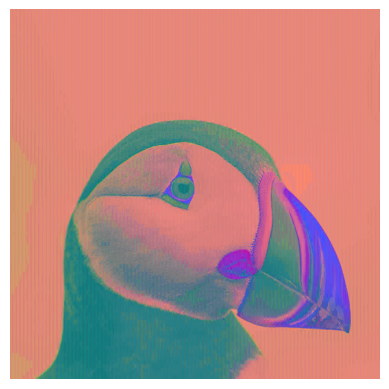

In [38]:
show_image(inverse_dct)

In [39]:
final_rgb = ycbcr2rgb(inverse_dct)

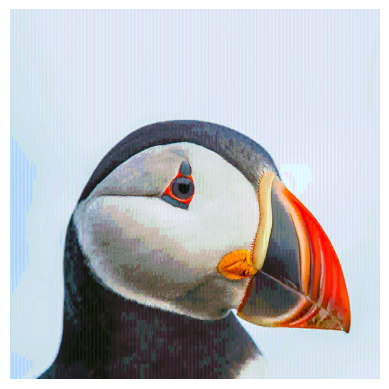

In [40]:
show_image(final_rgb)

## Final

In [41]:
quantization_matrix = np.array([
    [
        [16,  11,  10,  16,  24,  40,  51,  61],
        [12,  12,  14,  19,  26,  58,  60,  55],
        [14,  13,  16,  24,  40,  57,  69,  56],
        [14,  17,  22,  29,  51,  87,  80,  62],
        [18,  22,  37,  56,  68, 109, 103,  77],
        [24,  35,  55,  64,  81, 104, 113,  92],
        [49,  64,  78,  87, 103, 121, 120, 101],
        [72,  92,  95,  98, 112, 100, 103,  99]
    ],
    # Repeat the same matrix for chrominance (Cb and Cr) components
    [
        [17,  18,  24,  47,  99,  99,  99,  99],
        [18,  21,  26,  66,  99,  99,  99,  99],
        [24,  26,  56,  99,  99,  99,  99,  99],
        [47,  66,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99]
    ],
    # Repeat the same matrix for chrominance (Cb and Cr) components
    [
        [17,  18,  24,  47,  99,  99,  99,  99],
        [18,  21,  26,  66,  99,  99,  99,  99],
        [24,  26,  56,  99,  99,  99,  99,  99],
        [47,  66,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99]
    ]
])


In [42]:
def encode(image_path):
    image_path = image_path
    image_array = read_image(image_path)
    
    uncompressed_size = calculate_image_size(image_array) / (8 * 1000)
    print(f'uncompressed: {uncompressed_size} KB')
    low_chroma_array = rgb2ycbcr(image_array)
    dct_coefficients = perform_dct(low_chroma_array)

    quantized_coefficients = quantize_dct_coefficients(dct_coefficients, quantization_matrix)

    flattened_coefficients = quantized_coefficients.flatten()
    coefficient_counts = Counter(flattened_coefficients)
    huffman_tree = find_huffman(coefficient_counts)
    encoded_image = encode_quantized_coefficients(huffman_tree, quantized_coefficients)
    
    compressed_size = calculate_huffman_size(huffman_tree, encoded_image) / ( 8 * 1000)
    print(f'compressed: {compressed_size} KB')

    compression_ratio = uncompressed_size / compressed_size
    print(f'compression ratio: {compression_ratio}')
    return huffman_tree, encoded_image, compression_ratio

In [43]:
def decode(huffman_tree, encoded_image):
    decoded_image = np.array(decode_huffman(encoded_image, huffman_tree)).reshape((10000, 8, 8, 3))
    dequantized = inverse_quantize(decoded_image, quantization_matrix)
    inverse_dct = reconstruct_image(dequantized, (800, 800, 3))
    final_rgb = ycbcr2rgb(inverse_dct)
    return final_rgb

In [44]:
huffman_tree, encoded_image, compression_ratio = encode("slider_puffin_before_mobile.jpg")

uncompressed: 1920.0 KB
compressed: 400.29625 KB
compression ratio: 4.796447630973311


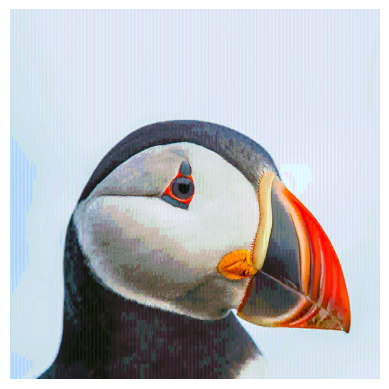

In [45]:
output = decode(huffman_tree, encoded_image)
show_image(output)

# امتیازی

## ماتریس های کوانتیزاسیون مختلف

uncompressed: 1920.0 KB
compressed: 400.29625 KB
compression ratio: 4.796447630973311


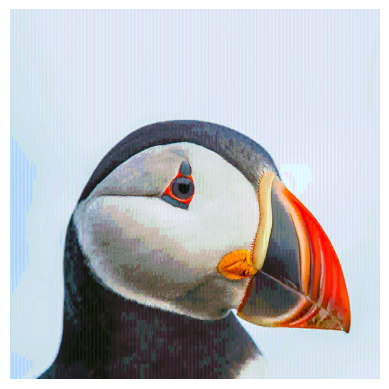

In [46]:
quantization_matrix = np.array([
    [
        [16,  11,  10,  16,  24,  40,  51,  61],
        [12,  12,  14,  19,  26,  58,  60,  55],
        [14,  13,  16,  24,  40,  57,  69,  56],
        [14,  17,  22,  29,  51,  87,  80,  62],
        [18,  22,  37,  56,  68, 109, 103,  77],
        [24,  35,  55,  64,  81, 104, 113,  92],
        [49,  64,  78,  87, 103, 121, 120, 101],
        [72,  92,  95,  98, 112, 100, 103,  99]
    ],
    # Repeat the same matrix for chrominance (Cb and Cr) components
    [
        [17,  18,  24,  47,  99,  99,  99,  99],
        [18,  21,  26,  66,  99,  99,  99,  99],
        [24,  26,  56,  99,  99,  99,  99,  99],
        [47,  66,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99]
    ],
    # Repeat the same matrix for chrominance (Cb and Cr) components
    [
        [17,  18,  24,  47,  99,  99,  99,  99],
        [18,  21,  26,  66,  99,  99,  99,  99],
        [24,  26,  56,  99,  99,  99,  99,  99],
        [47,  66,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99]
    ]
])
huffman_tree, encoded_image, compression_ratio = encode("slider_puffin_before_mobile.jpg")
output = decode(huffman_tree, encoded_image)
show_image(output)

uncompressed: 1920.0 KB
compressed: 400.909625 KB
compression ratio: 4.78910926620931


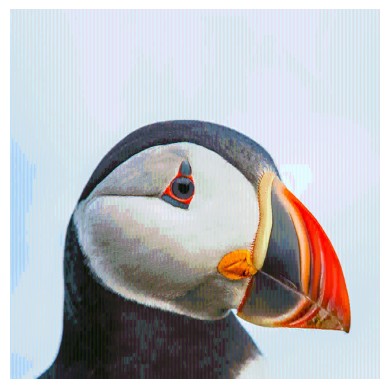

In [47]:
quantization_matrix = np.array([
    [
        [12,  16,  19,  22,  26,  27,  29,  34],
        [16,  16,  22,  24,  27,  29,  34,  37],
        [19,  22,  26,  27,  29,  34,  37,  38],
        [22,  24,  27,  29,  34,  37,  38,  39],
        [26,  27,  29,  32,  35,  39,  40,  44],
        [27,  29,  34,  37,  39,  40,  44,  48],
        [29,  34,  37,  38,  40,  44,  48,  58],
        [34,  37,  38,  39,  44,  48,  58,  69]
    ],
    # Repeat the same matrix for chrominance (Cb and Cr) components
    [
        [17,  18,  24,  47,  99,  99,  99,  99],
        [18,  21,  26,  66,  99,  99,  99,  99],
        [24,  26,  56,  99,  99,  99,  99,  99],
        [47,  66,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99]
    ],
    # Repeat the same matrix for chrominance (Cb and Cr) components
    [
        [17,  18,  24,  47,  99,  99,  99,  99],
        [18,  21,  26,  66,  99,  99,  99,  99],
        [24,  26,  56,  99,  99,  99,  99,  99],
        [47,  66,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99]
    ]
])
huffman_tree, encoded_image, compression_ratio = encode("slider_puffin_before_mobile.jpg")
output = decode(huffman_tree, encoded_image)
show_image(output)

uncompressed: 1920.0 KB
compressed: 430.0535 KB
compression ratio: 4.464560804644074


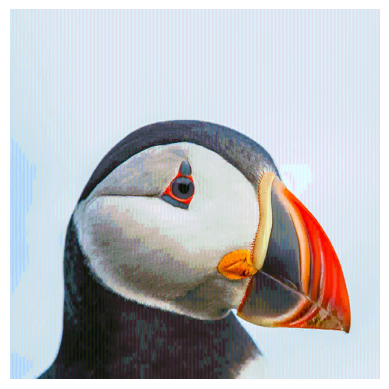

In [48]:
quantization_matrix = np.array([
    [
        [6,  4,  4,  6,  10,  16,  20,  24],
        [5,  5,  6,  8,  10,  23,  24,  22],
        [6,  5,  6,  10, 16,  23,  28,  22],
        [6,  7,  9,  12, 20,  35,  32,  25],
        [7,  9,  15, 22, 27,  44,  41,  31],
        [10, 14, 22, 26, 32,  42,  45,  37],
        [20, 26, 31, 35, 41,  48,  48,  40],
        [29, 37, 38, 39, 45,  40,  41,  40]
    ],
    # Repeat the same matrix for chrominance (Cb and Cr) components
    [
        [17,  18,  24,  47,  99,  99,  99,  99],
        [18,  21,  26,  66,  99,  99,  99,  99],
        [24,  26,  56,  99,  99,  99,  99,  99],
        [47,  66,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99]
    ],
    # Repeat the same matrix for chrominance (Cb and Cr) components
    [
        [17,  18,  24,  47,  99,  99,  99,  99],
        [18,  21,  26,  66,  99,  99,  99,  99],
        [24,  26,  56,  99,  99,  99,  99,  99],
        [47,  66,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99]
    ]
])
huffman_tree, encoded_image, compression_ratio = encode("slider_puffin_before_mobile.jpg")
output = decode(huffman_tree, encoded_image)
show_image(output)

uncompressed: 1920.0 KB
compressed: 433.242875 KB
compression ratio: 4.431694346964159


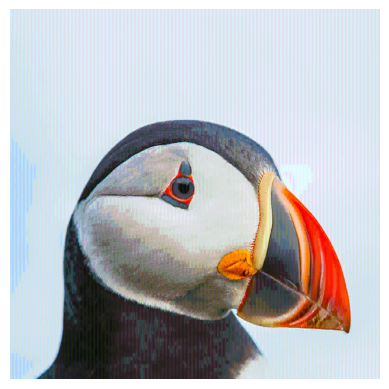

In [49]:
quantization_matrix = np.array([
    [
        [3,  5,  7,  9,  11,  13,  15,  17],
        [5,  7,  9,  11, 13,  15,  17,  19],
        [7,  9,  11, 13,  15,  17,  19,  21],
        [9,  11, 13,  15,  17,  19,  21,  23],
        [11, 13,  15,  17,  19,  21,  23,  25],
        [13,  15,  17,  19,  21,  23,  25,  27],
        [15,  17,  19,  21,  23,  25,  27,  29],
        [17,  19,  21,  23,  25,  27,  29,  31]
    ],
    # Repeat the same matrix for chrominance (Cb and Cr) components
    [
        [17,  18,  24,  47,  99,  99,  99,  99],
        [18,  21,  26,  66,  99,  99,  99,  99],
        [24,  26,  56,  99,  99,  99,  99,  99],
        [47,  66,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99]
    ],
    # Repeat the same matrix for chrominance (Cb and Cr) components
    [
        [17,  18,  24,  47,  99,  99,  99,  99],
        [18,  21,  26,  66,  99,  99,  99,  99],
        [24,  26,  56,  99,  99,  99,  99,  99],
        [47,  66,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99],
        [99,  99,  99,  99,  99,  99,  99,  99]
    ]
])
huffman_tree, encoded_image, compression_ratio = encode("slider_puffin_before_mobile.jpg")
output = decode(huffman_tree, encoded_image)
show_image(output)

## فضاهای رنگی مختلف

### HSV

In [50]:
def rgb2hsv(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return hsv_image

In [51]:
def hsv2rgb(image):
    # Convert image to the appropriate data type
    image = image.astype(np.uint8)

    # Convert HSV to RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return rgb_image

In [56]:
def encode(image_path):
    image_path = image_path
    image_array = read_image(image_path)
    
    uncompressed_size = calculate_image_size(image_array) / (8 * 1000)
    print(f'uncompressed: {uncompressed_size} KB')
    low_chroma_array = rgb2hsv(image_array)
    dct_coefficients = perform_dct(low_chroma_array)

    quantized_coefficients = quantize_dct_coefficients(dct_coefficients, quantization_matrix)

    flattened_coefficients = quantized_coefficients.flatten()
    coefficient_counts = Counter(flattened_coefficients)
    huffman_tree = find_huffman(coefficient_counts)
    encoded_image = encode_quantized_coefficients(huffman_tree, quantized_coefficients)
    
    compressed_size = calculate_huffman_size(huffman_tree, encoded_image) / ( 8 * 1000)
    print(f'compressed: {compressed_size} KB')

    compression_ratio = uncompressed_size / compressed_size
    print(f'compression ratio: {compression_ratio}')
    return huffman_tree, encoded_image, compression_ratio

In [57]:
def decode(huffman_tree, encoded_image):
    decoded_image = np.array(decode_huffman(encoded_image, huffman_tree)).reshape((10000, 8, 8, 3))
    dequantized = inverse_quantize(decoded_image, quantization_matrix)
    inverse_dct = reconstruct_image(dequantized, (800, 800, 3))
    final_rgb = hsv2rgb(inverse_dct)
    return final_rgb

uncompressed: 1920.0 KB
compressed: 491.51525 KB
compression ratio: 3.90628774997317


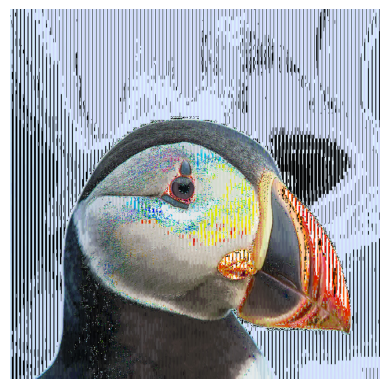

In [58]:
coefficient_counts, encoded_image, compression_ratio = encode("slider_puffin_before_mobile.jpg")
output = decode(coefficient_counts, encoded_image, )
show_image(output)

## visulization

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dct_coefficient(dct_coefficients, coefficient_index):
    # Select the DCT coefficient from the matrix
    coefficient = dct_coefficients[coefficient_index]

    # Rescale the coefficient values to the range [0, 255]
    rescaled_coefficient = (coefficient - np.min(coefficient)) / (np.max(coefficient) - np.min(coefficient))

    # Create a grayscale image from the integer coefficient
    plt.imshow(rescaled_coefficient)
    plt.axis('off')
    plt.show()


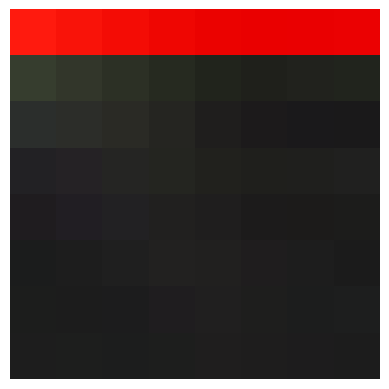

In [60]:
visualize_dct_coefficient(dct_coefficients,3333)

## کد گذاری حسابی

In [63]:
def get_cumulative_probabilities(probabilities):
    cumulative_probs = {}
    cum_prob = 0.0
    for symbol, prob in probabilities.items():
        cum_prob += prob
        cumulative_probs[symbol] = cum_prob
    return cumulative_probs


def arithmetic_encode(sequence, cumulative_probs):
    # Get the total number of symbols in the sequence
    num_symbols = len(sequence)
    
    # Initialize the interval and range
    interval = 0.0
    range_width = 1.0

    # Encode the symbols in the sequence
    for symbol in sequence:
        symbol_prob = cumulative_probs[symbol]
        interval += range_width * symbol_prob
        range_width *= cumulative_probs.get(symbol + 1, 0) - symbol_prob
    
    # Return the encoded interval
    return interval



In [72]:
def encode(image_path):
    image_array = read_image(image_path)
    
    uncompressed_size = calculate_image_size(image_array) / (8 * 1000)
    print(f'uncompressed: {uncompressed_size} KB')
    
    low_chroma_array = rgb2ycbcr(image_array)
    dct_coefficients = perform_dct(low_chroma_array)
    quantized_coefficients = quantize_dct_coefficients(dct_coefficients, quantization_matrix)
    
    #########################################################################################################
    flattened_coefficients = quantized_coefficients.flatten()
    coefficient_counts = Counter(flattened_coefficients)
    num_symbols = len(flattened_coefficients)

    probabilities = {}
    for symbol, count in coefficient_counts.items():
        probabilities[symbol] = count / num_symbols
    
    encoded_image = arithmetic_encode(flattened_coefficients, get_cumulative_probabilities(probabilities))
    
    # print(encoded_image)
    ##########################################################################################################
    
    compressed_size = len(str(encoded_image) * 32) + len(probabilities) / (8 * 1000)
    print(f'compressed: {compressed_size} KB')

    compression_ratio = uncompressed_size / compressed_size
    print(f'compression ratio: {compression_ratio}')
    
    return coefficient_counts, encoded_image, num_symbols, compression_ratio

In [73]:
coefficient_counts, encoded_image, num_symbols, compression_ratio = encode("slider_puffin_before_mobile.jpg")

uncompressed: 1920.0 KB
compressed: 640.036625 KB
compression ratio: 2.9998283301365762


In [77]:
def arithmetic_decode(encoded_value, probabilities, num_symbols):
    # Create cumulative probability distribution
    cumulative_probs = [0] + list(np.cumsum(probabilities))

    # Initialize interval [0, 1) and range [0, 1)
    interval = encoded_value
    range_width = 1

    sequence = []

    for _ in range(num_symbols):
        for symbol, symbol_prob in enumerate(probabilities):
            symbol_range_start = cumulative_probs[symbol]
            symbol_range_end = cumulative_probs[symbol + 1]

            if symbol_range_start <= interval < symbol_range_end:
                # Output the symbol
                sequence.append(symbol)

                # Update interval and range
                interval = (interval - symbol_range_start) / 
                range_width
                range_width *= symbol_prob
                break

    return sequence

def decode(probabilities, num_symbols, encoded_image):
    decoded_image = np.array(arithmetic_decode(encoded_image, probabilities, num_symbols)).reshape((10000, 8, 8, 3))
    dequantized = inverse_quantize(decoded_image, quantization_matrix)
    inverse_dct = reconstruct_image(dequantized, (800, 800, 3))
    final_rgb = ycbcr2rgb(inverse_dct)
    return final_rgb

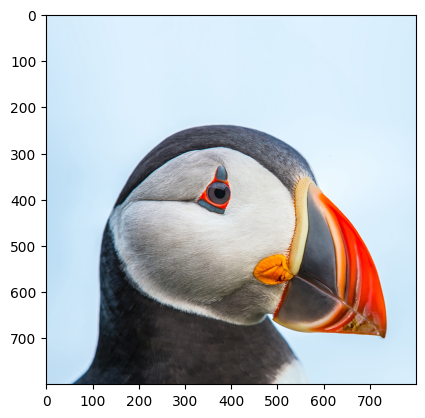

In [79]:
output = decode(coefficient_counts, num_symbols, encoded_image)
show_image(output)

# K-means

In [522]:
def k_means_compression(image, k, max_iters=100, threshold=1e-5):
    """
    Performs k-means compression on the input image.

    Args:
        image: The input image as a NumPy array with shape (width, height, 3).
        k: The number of clusters/centroids.
        max_iterations: Maximum number of iterations to run the algorithm.
        tolerance: The convergence tolerance for centroid change.

    Returns:
        compressed_image: The compressed image as a NumPy array with the same shape as the input image.

    """
    # Reshape the image into a flattened array of pixels
    pixels = image.reshape(-1, 3)
    
    # Step 1: K-means++ Initialization
    centroids = kmeans_plusplus_initialization(pixels, k)
    
    # Step 2: K-means Clustering
    while True:
        # Step 3: Assign pixels to nearest centroid
        labels = assign_labels(pixels, centroids)
        
        # Step 4: Update centroids
        new_centroids = update_centroids(pixels, labels, k)
        
        # Step 5: Check convergence
        if np.linalg.norm(new_centroids - centroids) < threshold:
            break
        
        centroids = new_centroids
    
    # Step 6: Replace pixel values with nearest centroid
    compressed_image = centroids[labels]
    
    # Reshape the compressed image back to its original shape
    compressed_image = compressed_image.reshape(image.shape)
    
    return compressed_image

In [522]:
def kmeans_plusplus_initialization(pixels, k):
    """
    This method improves the chances of selecting good initial centroids by considering the distance between points.
    It starts by randomly selecting one centroid, and then selects subsequent centroids with a probability
    proportional to their distance from the existing centroids.
    """
    centroids = []
    
    # Choose the first centroid randomly
    centroid = pixels[np.random.choice(pixels.shape[0])]
    centroids.append(centroid)
    
    # Calculate the distances to the existing centroids
    distances = np.linalg.norm(pixels - centroid, axis=1)
    
    for _ in range(1, k):
        # Choose the next centroid with probability proportional to squared distance
        probabilities = distances ** 2
        probabilities /= np.sum(probabilities)
        
        centroid = pixels[np.random.choice(pixels.shape[0], p=probabilities)]
        centroids.append(centroid)
        
        # Update the distances to the existing centroids
        new_distances = np.linalg.norm(pixels - centroid, axis=1)
        distances = np.minimum(distances, new_distances)
    
    return np.array(centroids)

In [522]:
def assign_labels(data, centroids):
    """
    Assigns each data point to the nearest centroid.

    Args:
        data: The input data as a 2D array.
        centroids: The current centroids as a 2D array.

    Returns:
        labels: The assigned labels as a 1D array.
    """
    distances = np.linalg.norm(data[:, np.newaxis, :] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)
    return labels


def update_centroids(data, labels, k):
    """
    Updates the centroids based on the current assignments.

    Args:
        data: The input data as a 2D array.
        labels: The current labels as a 1D array.
        k: The number of centroids.

    Returns:
        centroids: The updated centroids as a 2D array.
    """
    centroids = np.empty((k, data.shape[1]))
    for i in range(k):
        mask = (labels == i)
        cluster_points = data[mask]
        centroids[i] = np.mean(cluster_points, axis=0)
    return centroids

In [522]:
def replace_pixels(data, labels, centroids):
    """
    Replaces each data point with its corresponding centroid value.

    Args:
        data: The input data as a 2D array.
        labels: The current labels as a 1D array.
        centroids: The current centroids as a 2D array.

    Returns:
        replaced_data: The data with replaced pixels as a 2D array.
    """
    replaced_data = centroids[labels]
    return replaced_data

In [525]:
result = k_means_compression(image_array, 15)

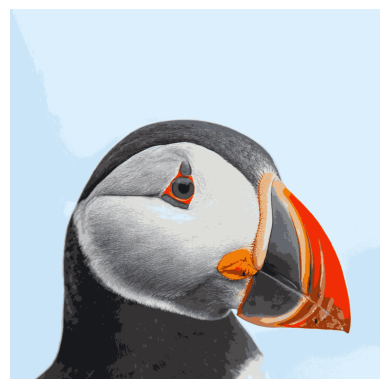

In [526]:
show_image(result)